In [14]:
# 🚢 Titanic Survival Prediction – End-to-End Machine Learning Pipeline

# This notebook covers the complete workflow of building a classification model to predict survival of passengers on the Titanic using machine learning.

In [15]:
## Step 1: Importing Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Ensure outputs directory exists
os.makedirs('outputs', exist_ok=True)

In [16]:
## Step 3: Preprocess the Data

def preprocess(df):
    df = df.copy()
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
    df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True, errors='ignore')
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

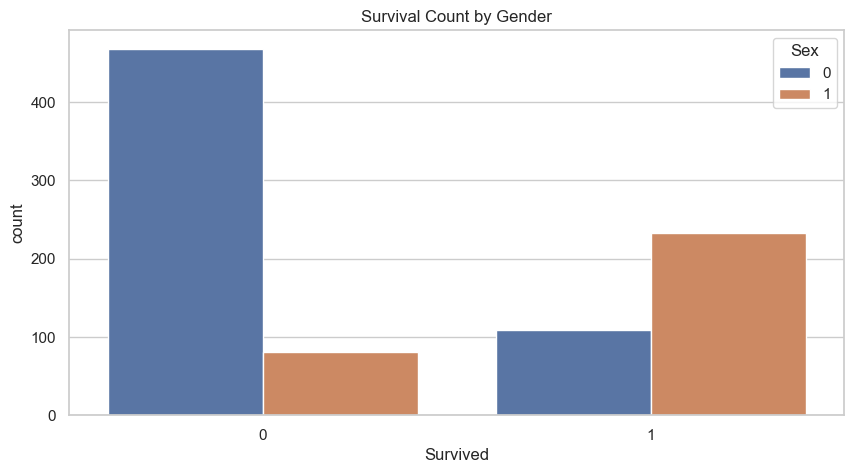

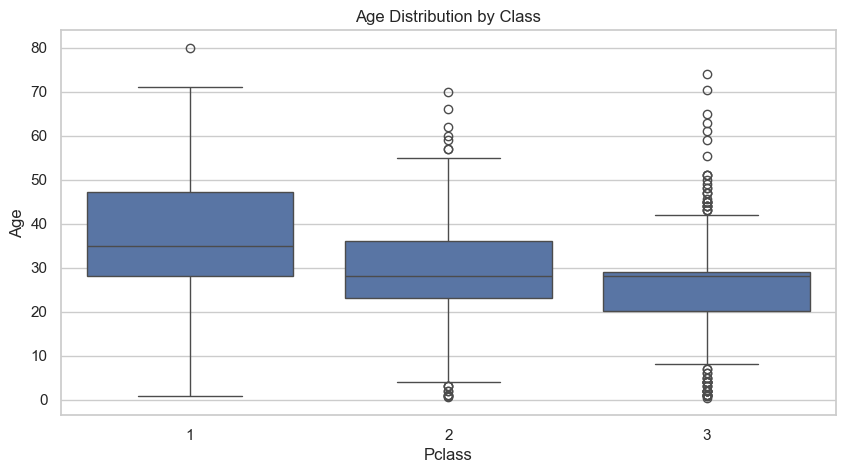

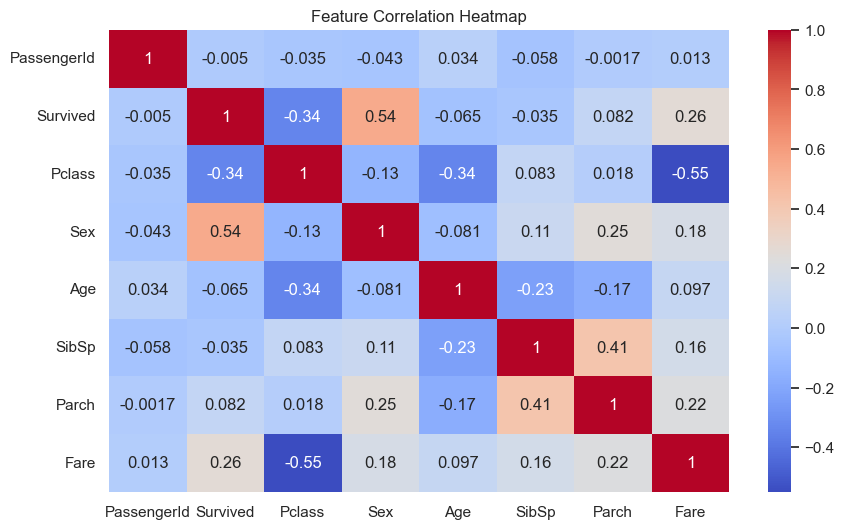

In [17]:
## Step 4: Exploratory Data Analysis (EDA)
def visualize_data(df):
    sns.set(style='whitegrid')

    # Plot 1
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Survived', hue='Sex', data=df)
    plt.title('Survival Count by Gender')
    plt.savefig('outputs/survival_by_gender.png')
    plt.show()

    # Plot 2
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Pclass', y='Age', data=df)
    plt.title('Age Distribution by Class')
    plt.savefig('outputs/age_by_class.png')
    plt.show()

    # Plot 3
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.savefig('outputs/correlation_heatmap.png')
    plt.show()

visualize_data(train_df)

In [18]:
## Step 5: Train-Test Split

X = train_df.drop(['Survived', 'PassengerId'], axis=1)
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
## Step 6: Hyperparameter Tuning (Random Forest)

def tune_model(X, y):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }

    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)

    print("Best Parameters:", grid.best_params_)
    print("Best Cross-Validated Accuracy:", grid.best_score_)

    return grid.best_estimator_

model = tune_model(X_train, y_train)

Best Parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Cross-Validated Accuracy: 0.8300206835418102


Validation Accuracy: 0.8156424581005587

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



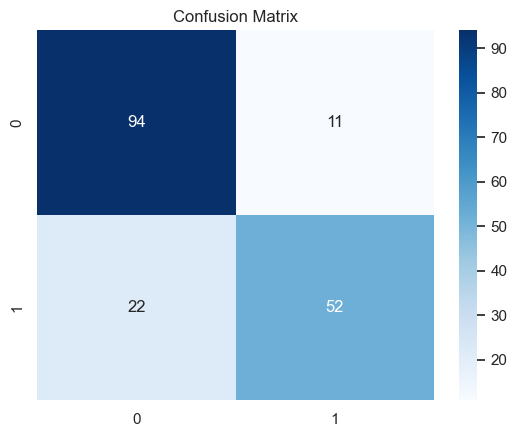

ROC AUC Score: 0.8924710424710426


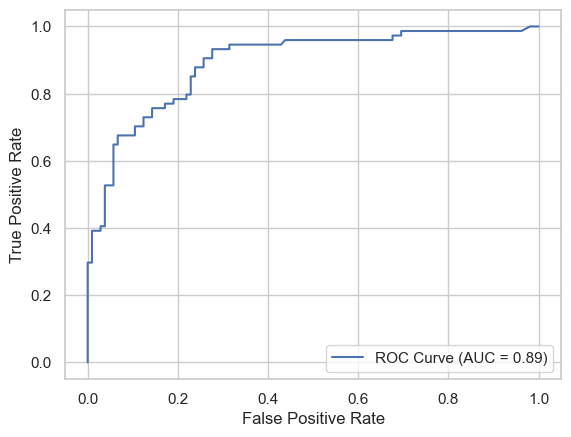

In [20]:
## Step 7: Evaluate the Model

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('outputs/confusion_matrix.png')
    plt.show()

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, probs)
        fpr, tpr, _ = roc_curve(y_val, probs)
        print("ROC AUC Score:", auc)

        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.savefig('outputs/roc_curve.png')
        plt.show()

evaluate_model(model, X_val, y_val)

In [21]:
## Step 8: Save the Model

def save_model(model):
    joblib.dump(model, 'outputs/final_model.pkl')
    print("Model saved to outputs/final_model.pkl")

save_model(model)

Model saved to outputs/final_model.pkl


In [22]:
## Step 9: Generate Submission File

def predict_test(model, test_df):
    test_ids = test_df['PassengerId']
    test_df = test_df.drop(['PassengerId'], axis=1)

    predictions = model.predict(test_df)

    submission = pd.DataFrame({
        'PassengerId': test_ids,
        'Survived': predictions
    })
    submission.to_csv('outputs/my_submission.csv', index=False)
    print("Submission saved as outputs/my_submission.csv")

predict_test(model, test_df)


Submission saved as outputs/my_submission.csv
